### status

Proverit da li fixovanje ruta menja rute <br>
Unit testovi


In [1]:
import random
from copy import deepcopy
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def load(file):
    cities = []
    with open(file, 'r') as f:
        for line in f:
            data = line.split()
            city_num = int(data[0])-1
            x = float(data[1])
            y = float(data[2])
            demand = float(data[3])
            ready_time = float(data[4])
            due_time = float(data[5])
            
            city = {'city_num' : city_num, 'x' : x, 'y' : y, 'demand' : demand, 'ready_time' : ready_time, 'due_time' : due_time}
            cities.append(city)
            
    return cities   

In [3]:
input1 = load('resources/input_1.txt')
input2 = load('resources/input_2.txt')
input3 = load('resources/input_3.txt')

for x in input2:
    print(x)

{'city_num': 0, 'x': 40.0, 'y': 50.0, 'demand': 0.0, 'ready_time': 0.0, 'due_time': 1236.0}
{'city_num': 1, 'x': 45.0, 'y': 68.0, 'demand': 10.0, 'ready_time': 912.0, 'due_time': 967.0}
{'city_num': 2, 'x': 45.0, 'y': 70.0, 'demand': 30.0, 'ready_time': 825.0, 'due_time': 870.0}
{'city_num': 3, 'x': 42.0, 'y': 66.0, 'demand': 10.0, 'ready_time': 65.0, 'due_time': 146.0}
{'city_num': 4, 'x': 42.0, 'y': 68.0, 'demand': 10.0, 'ready_time': 727.0, 'due_time': 782.0}
{'city_num': 5, 'x': 42.0, 'y': 65.0, 'demand': 10.0, 'ready_time': 15.0, 'due_time': 67.0}
{'city_num': 6, 'x': 40.0, 'y': 69.0, 'demand': 20.0, 'ready_time': 621.0, 'due_time': 702.0}
{'city_num': 7, 'x': 40.0, 'y': 66.0, 'demand': 20.0, 'ready_time': 170.0, 'due_time': 225.0}
{'city_num': 8, 'x': 38.0, 'y': 68.0, 'demand': 20.0, 'ready_time': 255.0, 'due_time': 324.0}
{'city_num': 9, 'x': 38.0, 'y': 70.0, 'demand': 10.0, 'ready_time': 534.0, 'due_time': 605.0}
{'city_num': 10, 'x': 35.0, 'y': 66.0, 'demand': 10.0, 'ready_tim

In [4]:
class Individual:
    def __init__(self, data, capacity, num_of_vehicles, service_time):
        self.num_of_vehicles = num_of_vehicles
        self.num_of_cities = len(data) - 1
        self.depot = data[0]
        self.data = data
        self.distance_between_cities = self.calc_all_distances()
        self.capacity = capacity
        self.service_time = service_time
        self.time_penalty = 2
        self.capacity_penalty = 5
        self.tolerance = 1
        self.solution = self.initial_solution_nearest_neighbors()
        self.fitness = self.calc_fitness()

    def __len__(self) -> int:
        return len(self.solution)
    
    def calc_distance(self, city1, city2) -> float:
        distance = math.sqrt((city1["x"] - city2["x"])**2 + (city1["y"] - city2["y"])**2)
        return round(distance, 3)
    
    def calc_all_distances(self) -> [[float]]:
        all_distances = [[0 for _ in range(len(self.data))] for _ in range(len(self.data))]
        
        for i in range(len(self.data)):
            for j in range(len(self.data)):
                if i != j:
                    distance = self.calc_distance(self.data[i], self.data[j])
                    all_distances[i][j] = distance
                else:
                    all_distances[i][j] = 0
                
        return all_distances

    def initial_solution_random(self):
        routes = [[] for _ in range(self.num_of_vehicles)]
        remaining = set(range(1, self.num_of_cities + 1))

        
        while remaining:
            customer_index = random.choice(list(remaining))
            id = 0
            for j in range(self.num_of_vehicles):
                route = deepcopy(routes[j])
                route.append(customer_index)
                if not self.is_route_unfeasible(route)[0]:
                    routes[j] = deepcopy(route)
                    remaining.remove(customer_index)
                    id = 1
                    break
            if id == 0: #ako nije pronadjena feasible ruta, restartujemo alg
                routes = [[] for _ in range(self.num_of_vehicles)]
                remaining = set(range(1, self.num_of_cities + 1))

        return self.create_solution(routes)

    def initial_solution_nearest_neighbors(self):
        routes = [[] for _ in range(self.num_of_vehicles)]
        remaining_cities = [i for i in range(1, self.num_of_cities + 1)]
        
        return self.generate_solution_nearest_neighbors(routes, remaining_cities)
    
    def get_feasible_cities(self, remaining_cities, start_city, current_time, capacity):
            feasible_cities = [(next_city, round(max(self.distance_between_cities[start_city][next_city], 
                                       self.data[next_city]["ready_time"] - current_time - self.service_time), 3)) 
                               for next_city in remaining_cities \
                               if round(current_time + self.distance_between_cities[start_city][next_city] + \
                                        self.service_time, 3) <= 
                                  self.data[next_city]["due_time"] + self.tolerance and \
                                  capacity >= self.data[next_city]["demand"]]
            
            feasible_cities.sort(key = lambda x: x[1])
            return feasible_cities
    
    
    def generate_feasible_routes(self, routes, remaining_cities, prob) -> [[int]]: 
        for route in routes:
            while True:
                if not route:
                    feasible_cities = self.get_feasible_cities(remaining_cities, 0, 0, self.capacity)
                else:
                    _, current_time, remaining_capacity = self.route_fitness(route)
                    feasible_cities = self.get_feasible_cities(remaining_cities, route[-1], current_time, remaining_capacity)

                if not feasible_cities:
                    break
                    
                if random.random() < prob:
                    city_index = random.choice(feasible_cities)[0]
                else:
                    city_index = feasible_cities[0][0]

                remaining_cities.remove(city_index)
                route.append(city_index)

                is_unfeasible, _ = self.is_route_unfeasible(route)
                if is_unfeasible:
                    route.pop(-1)
                    remaining_cities.append(city_index)
                    continue
    
        if not remaining_cities:
            return routes
        
        # create an unfeasible route
        for route in routes:
            if not route:
                for city in remaining_cities:
                    route.append(city)
                    is_unfeasible, _ = self.is_route_unfeasible(route)
                    print('is unfeasible:', is_unfeasible)
                    if is_unfeasible:
                        route.pop(-1)
                        remaining_cities.append(city)
                        break 
        
        return routes
        
    def generate_solution_nearest_neighbors(self, routes, remaining_cities) -> [int]:        
        generated_routes = self.generate_feasible_routes(routes = routes, remaining_cities = remaining_cities, prob = 0.7)
        return self.create_solution(generated_routes)

    def create_solution(self, routes) -> [int]:
        solution = []
        for i, route in enumerate(routes):
            for city in route:
                solution.append(city)
            solution.append(self.num_of_cities + i + 1)
        
        # remove empty routes
        for city in reversed(solution):
            if city > self.num_of_cities:
                solution.pop(-1)
            else:
                break
                
        return solution


    def is_route_unfeasible(self, route) -> (bool, int):
        if not route:
            return False, None
        
        current_time = 0
        previous_city = 0
        remaining_capacity = self.capacity 
        
        for current_city in route:
            current_city_data = self.data[current_city]
            distance = self.distance_between_cities[previous_city][current_city] 
            
            if round(current_time + distance + self.service_time, 3) > current_city_data["due_time"] + self.tolerance:
                # print('\ntime violation')
                # print('current time + distance + service time =:', round(current_time + distance + self.service_time, 3))
                # print('city due time + tolerance =', current_city_data["due_time"] + self.tolerance)
                # print('city that produced violation:', current_city)
                # print('in route: ', route)
                return True, current_city 
            
            elif remaining_capacity < current_city_data["demand"]:
                print('\ncapacity violation')
                print('city that produced violation:', current_city)
                print('in route: ', route)

                return True, current_city
                
            current_time += distance + self.service_time
            previous_city = current_city
            remaining_capacity -= current_city_data["demand"]
            
        # return to depot
        if round(current_time + self.distance_between_cities[previous_city][0], 3) > \
           self.depot["due_time"] + self.tolerance:
            print('\ntime violation - return to depot')
            print('city that produced violation:', previous_city)
            return True, previous_city
        
        return False, None
    
    def route_fitness(self, route) -> (float, float, float):
        if not route:
            return 0, 0, self.capacity
        
        fitness = 0
        current_time = 0
        previous_city = 0
        remaining_capacity = self.capacity
        
        for current_city in route:
            current_city_data = self.data[current_city]
            distance = self.distance_between_cities[previous_city][current_city]
            
            if round(current_time + distance + self.service_time, 3) > current_city_data["due_time"] + self.tolerance:
                fitness += (current_time + distance + self.service_time - current_city_data["due_time"])*self.time_penalty
                
            if remaining_capacity < current_city_data["demand"]:
                fitness += (current_city_data["demand"] - remaining_capacity)*self.capacity_penalty

            current_time += distance + self.service_time
            previous_city = current_city
            remaining_capacity -= current_city_data["demand"]
            
        fitness += current_time + self.distance_between_cities[previous_city][0]
        fitness /= len(route) # fitness normalization
        fitness = round(fitness, 3)
        
        return fitness, current_time, remaining_capacity
    
    def get_routes(self) -> [[int]]:
        routes = []
        route = []
        # all routes except for the last route
        for city_index in self.solution:
            if city_index <= self.num_of_cities:
                route.append(city_index)
            else:
                if len(route) > 0:
                    routes.append(route)
                route = []

        # last route
        if len(route) > 0:
            routes.append(route)

        return routes
    
    def calc_fitness(self) -> float:
        routes = self.get_routes()
        
        # more routes than available vehicles
        if sum(1 for r in routes if len(r) > 0) > self.num_of_vehicles:
            return float('inf')

        fitness = 0
        for route in routes:
            if len(route) == 0:
                continue
            f, _, _ = self.route_fitness(route)
            fitness += f
            
        return fitness

    def is_feasible(self) -> bool:
        visited = [False for _ in range(self.num_of_cities)]
        for c in self.solution:
            if c <= self.num_of_cities:
                if  not visited[c-1]:
                    visited[c-1] = True
                else:
                    #print("CUSTOMER ", c, "ALREADY VISITED!")
                    return False
        if not all(visited):
            #print("NOT ALL CUSTOMERS HAVE BEEN VISITED: ")
            # for i,v in enumerate(visited):
            #     if not v:
            #         print("\t", i)
            return False
        
        routes = self.get_routes()
        if sum(1 for r in routes if len(r) > 0) > self.num_of_vehicles:
            #print("more vehicles than available violation")
            return False

        for route in routes:
            is_unfeasible, _ = self.is_route_unfeasible(route)
            if is_unfeasible:
                return False
        
        return True
    
    def is_feasible_verbose(self) -> bool:
        visited = [False for _ in range(self.num_of_cities)]
        for c in self.solution:
            if c <= self.num_of_cities:
                if  not visited[c-1]:
                    visited[c-1] = True
                else:
                    print("CUSTOMER ", c, "ALREADY VISITED!")
                    return False
        if not all(visited):
            print("NOT ALL CUSTOMERS HAVE BEEN VISITED: ")
            for i,v in enumerate(visited):
                if not v:
                    print("\t", i)
            return False
        
        routes = self.get_routes()
        if sum(1 for r in routes if len(r) > 0) > self.num_of_vehicles:
            print("more vehicles than available violation")
            return False

        for route in routes:
            is_unfeasible, _ = self.is_route_unfeasible(route)
            if is_unfeasible:
                return False
        
        #print("Solution is feasible!")
        return True

# EXACT SOLUTION

In [ ]:
individual = Individual(input1[:6], 200, 50, 10)
remaining_cities = list(range(1, individual.num_of_cities+1))
routes = [[]]
best_sol = []
b_fitness = float('inf')

def brute_force(routes, remaining_cities, current_route):
    global b_fitness, best_sol
    
    if len(remaining_cities) == 0:
        fitness = 0
        for route in routes:
            fitness += individual.route_fitness(route)[0]
        print(routes)
        print(fitness)
        if fitness < b_fitness:
            b_fitness = fitness
            best_sol = deepcopy(routes)

        return 
    

    if len(routes[current_route]) > 0:
        _, current_time, capacity  = individual.route_fitness(routes[current_route])
        feasible_cities = [x[0] for x in individual.get_feasible_cities(remaining_cities=remaining_cities, start_city=routes[current_route][-1], current_time=current_time, capacity=capacity)]
    else:
        feasible_cities = remaining_cities

    if len(feasible_cities) == 0:
        routes.append([])
        brute_force(routes, remaining_cities, current_route + 1)
        print(routes)
        if len(routes[current_route+1]) > 0:
            remaining_cities.extend(routes[current_route + 1])
        routes.pop(-1)
    
    else:
        for city in feasible_cities:
            routes[current_route].append(city)
            remaining_cities.remove(city)
            print(routes)
            brute_force(routes, remaining_cities, current_route)
            
            routes[current_route].remove(city)
            remaining_cities.append(city)

            print(routes)
        if len(routes[current_route]) > 0:
            routes.append([])
            brute_force(routes, remaining_cities, current_route+1)
            routes.pop(-1)


brute_force(routes, remaining_cities, 0)
print(best_sol)
print(b_fitness)
    

# Selection

In [5]:
def random_selection(population):
    return random.choice(population)

In [6]:
def tournament_selection(population, tournament_size):
    tournament = random.sample(population, tournament_size)
    return max(tournament, key = lambda x: x.fitness)

In [7]:
def roulette_selection(population):
    total_fitness = sum([individual.fitness for individual in population])
    selection_probs = [individual.fitness / total_fitness for individual in population]
    return random.choices(population, weights=selection_probs)[0]

In [8]:
def rang_selection(population):
    n = len(population)
    rang_sum = n * (n+1) / 2
    selection_probs = []
    for rang, _ in enumerate(sorted(population, key=lambda x: x.fitness), 1):
        selection_probs.append(rang / rang_sum)
        
    return random.choices(population, weights=selection_probs)[0]

In [9]:
def selection(param, population):
    if param["tournament_size"] is not None:
        return param["selection"](population, param["tournament_size"])
    else:
        return param["selection"](population)

In [10]:
class Example_Individual:
    def __init__(self, fitness, name):
        self.fitness = fitness
        self.name = name

example_population = [Example_Individual(fitness=0.8, name='A'), 
                      Example_Individual(fitness=0.6, name='B'), 
                      Example_Individual(fitness=0.7, name='C'),
                      Example_Individual(fitness=0.8, name='D'), 
                      Example_Individual(fitness=0.9, name='E')]

print(random_selection(example_population).name)
print(tournament_selection(example_population, 3).name)
print(roulette_selection(example_population).name)
print(rang_selection(example_population).name)

E
A
E
B


# Crossover

In [11]:
def get_bounds_individual(quantity, segment_coef):
    lb = random.choice(range(quantity + 1))
    ub = random.choice(range(lb + 1, lb + quantity // segment_coef))
    
    ub = max(lb + 1 + segment_coef, ub)   # at least 'segment_coef' positions ahead
    ub = min(ub, quantity)   # at most at last position
    
    return lb, ub

def get_bounds(parent1, parent2, segment_coef):
    min_len = min(len(parent1.solution), len(parent2.solution))
    lb, ub = get_bounds_individual(min_len, 5)
    return lb, ub, min_len

In [34]:
def order_crossover(parent1, parent2, child1, child2):
    
    def create_child(p1, p2, ch, lb, ub, min_len):
        ch.solution = [None for _ in range(min_len)]
        ch.solution[lb:ub] = p1.solution[lb:ub]

        p2_index = ub
        ch_index = ub
        while None in ch.solution:
            if ch_index == len(ch.solution):
                ch_index = 0
            if p2_index == len(p2.solution):
                p2_index = 0
            if p2.solution[p2_index] not in ch.solution:
                ch.solution[ch_index] = p2.solution[p2_index]
                ch_index += 1
            p2_index += 1

    lb, ub, min_len = get_bounds(parent1, parent2, 5)
    create_child(parent1, parent2, child1, lb, ub, min_len)
    create_child(parent2, parent1, child2, lb, ub, min_len)

In [13]:
def partially_mapped_crossover(parent1, parent2, child1, child2):
    
    def partially_mapped_single_offspring(p1, p2, ch, lb, ub, min_size):
        ch.solution = [0 for _ in range(min_size)]
        ch.solution[lb:ub] = p1.solution[lb:ub]

        indices = list(range(0, lb))
        indices.extend(list(range(ub, min_size)))
        
        for i in indices:
            candidate = p2.solution[i]
            while candidate in ch.solution[lb:ub]:
                index = ch.solution.index(candidate)
                candidate = p2.solution[index]
            ch.solution[i] = candidate
    
    lb, ub, min_size = get_bounds(parent1, parent2, 5)
    partially_mapped_single_offspring(parent1, parent2, child1, lb, ub, min_size)
    partially_mapped_single_offspring(parent2, parent1, child2, lb, ub, min_size)

In [14]:
def best_route_better_adjustment_crossover(parent1, parent2, child1, child2):
    # n/2 best from parent1 into first n/2 of child1
    # the rest elements are from parent2 
    
    def create_child(p1, p2, ch):
        p1_routes = p1.get_routes()
        p1_routes.sort(key = lambda route: p1.route_fitness(route)[0])

        offspring = []
        route_idx = 0
        while route_idx <= len(p1_routes) / 2:
            offspring.extend(p1_routes[route_idx])
            route_idx += 1

        p2_routes = p2.get_routes()

        for route in p2_routes:
            for city in route:
                if city not in offspring:
                    offspring.append(city)
        
        ch.solution = offspring
    
    create_child(parent1, parent2, child1)
    create_child(parent2, parent1, child2)

In [15]:
def crossover(param, parent1, parent2, child1, child2):
    param["crossover"](parent1, parent2, child1, child2)

# Mutation

In [16]:
def swap_mutation(individual, l, r):
    if l == len(individual.solution):
        l -= 1
        
    if r == len(individual.solution):
        r -= 1
        
    individual.solution[l], individual.solution[r] = individual.solution[r], individual.solution[l]
    return individual.solution

In [17]:
def invert_mutation(individual, l, r):
    chosen = individual.solution[l:r]
    chosen.reverse()
    
    individual.solution[l:r] = deepcopy(chosen)
    return individual.solution

In [18]:
def shaking_mutation(individual, l, r):
    chosen = individual.solution[l:r]
    random.shuffle(chosen)

    individual.solution[l:r] = deepcopy(chosen)
    return individual.solution

In [19]:
def mutation(param, individual, mutation_prob):
    if random.random() < mutation_prob:
        l, r = get_bounds_individual(len(individual.solution), 5)
        return param["mutation"](individual, l, r)
    return individual.solution

In [20]:
def check_mutation(param):
    x = Individual(input1, 200, 50, 10)
    y = Individual(input1, 200, 50, 10)

    x_sol_old = deepcopy(x.solution)
    y_sol_old = deepcopy(y.solution)

    x_sol_new = deepcopy(mutation(param, x, 1))
    y_sol_new = deepcopy(mutation(param, y, 1))
    
    print('old x solution == new x solution:', x_sol_new == x_sol_old)
    print('old y solution == new y solution:', y_sol_new == y_sol_old)

    
print('-----------------------SWAP MUTATION-------------------------')
m_param = {"mutation" : swap_mutation}
check_mutation(m_param)

print('-----------------------INVERT MUTATION-------------------------')
m_param["mutation"] = invert_mutation
check_mutation(m_param)

print('-----------------------SHAKING MUTATION-------------------------')
m_param["mutation"] = shaking_mutation
check_mutation(m_param)

-----------------------SWAP MUTATION-------------------------
old x solution == new x solution: False
old y solution == new y solution: False
-----------------------INVERT MUTATION-------------------------
old x solution == new x solution: False
old y solution == new y solution: False
-----------------------SHAKING MUTATION-------------------------
old x solution == new x solution: False
old y solution == new y solution: False


# Fix solution


In [21]:
def insertion_based_repair(individual, offset):
    if (individual.is_feasible()):
        return individual
        
    routes = individual.get_routes()
    cities = range(1, individual.num_of_cities + 1)
    removed_cities_list = []

    # get unvisited cities
    for city in cities:
        if city not in individual.solution:        
            removed_cities_list.append(city)

    # get unfeasible routes
    unfeasible_routes = []
    for route in routes:
        is_unfeasible, _ = individual.is_route_unfeasible(route)
        if is_unfeasible:
            unfeasible_routes.append(route)

    # get feasible routes
    feasible_routes = []
    for route in routes:
        if route not in unfeasible_routes:
            feasible_routes.append(route)

    routes = deepcopy(feasible_routes)

    # remove excess routes
    if len(routes) > individual.num_of_vehicles:
        routes.sort(key = lambda route: individual.route_fitness(route)[0])
        while len(routes) > individual.num_of_vehicles:
            route = routes.pop(-1)
            removed_cities_list.extend(route)
          
    # remove unfeasible routes
    for i, _ in enumerate(unfeasible_routes):        
        unfeasible_routes[i].sort(key = lambda x: (individual.data[x]["ready_time"], individual.data[x]["due_time"]))
        
        # find and eliminate unfeasible cities
        while True:
            is_unfeasible, unfeasible_city = individual.is_route_unfeasible(unfeasible_routes[i])
            if not is_unfeasible:
                break
                
            removed_cities_list.append(unfeasible_city)
            unfeasible_routes[i].remove(unfeasible_city)   
        routes.append(unfeasible_routes[i])
    
    # first try: insert if possible in existing route
    if len(removed_cities_list) > 0:
        for removed_city in removed_cities_list:
            is_inserted = False
            for route_index, _ in enumerate(routes):            
                for city_index, _ in enumerate(routes[route_index]):
                    route_copy = deepcopy(routes[route_index]) 
                    route_copy.insert(city_index, removed_city)
                    
                    is_unfeasible, _ = individual.is_route_unfeasible(route_copy)
                    if not is_unfeasible:
                        routes[route_index] = deepcopy(route_copy)
                        is_inserted = True
                        removed_cities_list.remove(removed_city)
                        break
                        
                if is_inserted:
                    break

    # second try: create new routes 
    if len(removed_cities_list) > 0 and individual.num_of_vehicles - len(routes) > 0:
        new_routes = [[] for _ in range( individual.num_of_vehicles - len(routes) )]
        generated_routes = individual.generate_feasible_routes(new_routes, 
                                                               removed_cities_list, 
                                                               0.25 - offset)
        routes = routes + generated_routes

    individual.solution = individual.create_solution(routes)

# Debugging

In [22]:
def print_feasibility(x, y):
    print('\t', 'is x feasible:', x.is_feasible())
    print('\t', 'is y feasible:', y.is_feasible())
    print('\n########################################################\n')


def num_visited_cities(arr):
    visited = {}
    for city in arr:
        if city <= 100:
            visited[city] = False

    num_visited = 0
    for city in arr:
        if city > 100:
            continue
            
        if not visited[city]:
            visited[city] = True
            num_visited += 1
        else:
            print('city:', city, 'already visited!')
            
    return num_visited
    
def missing_cities(arr):
    my_cities = []
    for city in arr:
        if city <= 100:
            my_cities.append(city)
            
    my_cities.sort()
    
    missing_cities = []
    for i in range(len(my_cities) - 1):
        if my_cities[i+1] - my_cities[i] != 1:
            for missing_city in range(my_cities[i] + 1, my_cities[i+1]):
                missing_cities.append(missing_city)
    
    return missing_cities


def check_children(x_child, y_child, x_child_sol_old, y_child_sol_old):
    print_feasibility(x_child, y_child)
    
    print('If the answer is', colored('False', 'red'), 'then crossover updates children')
    print('X_child solution before and after crossover are equal:', x_child.solution == x_child_sol_old)
    print('Y_child solution before and after crossover are equal:', y_child.solution == y_child_sol_old, '\n')

    print('num of visited cities in c1:', num_visited_cities(x_child.solution))
    print('num of visited cities in c2:', num_visited_cities(y_child.solution))
    print('missing cities in c1:', missing_cities(x_child.solution))
    print('missing cities in c2:', missing_cities(y_child.solution))
    

    
def repair_children(x_child, y_child):
    print('\n----------------Insertion Based Repair---------------------')
    x_child_sol_old = x_child.solution
    insertion_based_repair(x_child, 0.1)

    y_child_sol_old = y_child.solution
    insertion_based_repair(y_child, 0.1)
    
    check_children(x_child, y_child, x_child_sol_old, y_child_sol_old)

    
def check_oc():
    x = Individual(input1, 200, 50, 10)
    y = Individual(input1, 200, 50, 10)
    x_child = Individual(input1, 200, 50, 10)
    y_child = Individual(input1, 200, 50, 10)

    x_child_sol_old = x_child.solution
    y_child_sol_old = y_child.solution
    
    print('\n--------------------Order Crossover--------------------')
    order_crossover(x, y, x_child, y_child)
    check_children(x_child, y_child, x_child_sol_old, y_child_sol_old)
    
    repair_children(x_child, y_child)
    
    
def check_pmc():
    x = Individual(input1, 200, 50, 10)
    y = Individual(input1, 200, 50, 10)
    x_child = Individual(input1, 200, 50, 10)
    y_child = Individual(input1, 200, 50, 10)

    x_child_sol_old = x_child.solution
    y_child_sol_old = y_child.solution
    
    print('\n--------------Partially Mapped Crossover-----------')
    partially_mapped_crossover(x, y, x_child, y_child)
    check_children(x_child, y_child, x_child_sol_old, y_child_sol_old)
    
    repair_children(x_child, y_child)
    
    
def check_brbac():
    x = Individual(input1, 200, 50, 10)
    y = Individual(input1, 200, 50, 10)
    x_child = Individual(input1, 200, 50, 10)
    y_child = Individual(input1, 200, 50, 10)

    x_child_sol_old = x_child.solution
    y_child_sol_old = y_child.solution
    
    print('\n--------------Best Route Better Adjustment Crossover-----------')
    best_route_better_adjustment_crossover(x, y, x_child, y_child)
    check_children(x_child, y_child, x_child_sol_old, y_child_sol_old)
    
    repair_children(x_child, y_child)

In [ ]:
from termcolor import colored

check_oc()
check_pmc()
check_brbac()

In [24]:
def change_num_of_vehicles(new_len, population):
    for individual in population:
        individual.num_of_vehicles = new_len
    return population

In [25]:
def check_and_update_num_of_vehicles(j, i, population):
    n1 = len(population[j].get_routes())
    n2 = len(population[i].get_routes())
    if max(n1,n2) > population[j].num_of_vehicles:
        population = change_num_of_vehicles(max(n1,n2), population)
    return population

# Genetic algorithm

In [32]:
def genetic_algorithm(params):
    
    data = params["data"]
    capacity = params["capacity"]
    num_of_vehicles = params["num_of_vehicles"]
    service_time = params["service_time"]
    population_size = params["population_size"]
    num_generations = params["num_generations"]
    elitism_size = params["elitism_size"]
    tournament_size = params["tournament_size"]
    mutation_prob = params["mutation_prob"]
    selection_params = params["selection"]
    
    population = [Individual(data, capacity, num_of_vehicles, service_time) for _ in range(population_size)]
    new_population = deepcopy(population)
  
    best_solutions = []
    for i in range(num_generations):
        population.sort(key = lambda x: x.fitness)
        best_solutions.append(population[0])
        new_population[:elitism_size] = population[:elitism_size]
        
        for j in range(elitism_size, population_size, 2):
            parent1 = selection(selection_params, population)
            parent2 = selection(selection_params, population)
            
            while(parent1 == parent2):
                parent2 = selection(selection_params, population)

            crossover(params, parent1, parent2, new_population[j], new_population[j+1])
    
            new_population[j].solution = deepcopy(mutation(params, new_population[j], mutation_prob))
            new_population[j+1].solution = deepcopy(mutation(params, new_population[j+1], mutation_prob))
            
            offset = min(i/400, 0.25)
            insertion_based_repair(new_population[j], offset)
            insertion_based_repair(new_population[j+1], offset)

            new_population[j].fitness = new_population[j].calc_fitness()
            new_population[j+1].fitness = new_population[j+1].calc_fitness()

            new_population = check_and_update_num_of_vehicles(j, j+1, new_population)
        
        population[:] = new_population[:]
        
    print("Number of vehicles after for loop: ", population[0].num_of_vehicles)
    return min(population, key = lambda x: x.fitness), best_solutions

In [ ]:
POPULATION_SIZE = 500
ELITISIM_SIZE = 70
MUTATION_PROB = 0.25
TOURNAMENT_SIZE = 300
NUM_GENERATIONS = 50
CAPACITY = 200
SELECTION = rang_selection
CROSSOVER = order_crossover
MUTATION = shaking_mutation
NUM_OF_VEHICLES = 50
SERVICE_TIME = 10

if POPULATION_SIZE % 2 != ELITISIM_SIZE % 2:
    ELITISIM_SIZE -= 1

params = {
    "data" : input1,
    "population_size" : POPULATION_SIZE,
    "elitism_size" : ELITISIM_SIZE,
    "mutation_prob" : MUTATION_PROB,
    "tournament_size" : TOURNAMENT_SIZE,
    "num_generations" : NUM_GENERATIONS,
    "capacity" : CAPACITY,
    "selection" : { "selection" : SELECTION, 
                    "tournament_size" : TOURNAMENT_SIZE if SELECTION.__name__ == "tournament_selection" else None
                  },
    "crossover" : CROSSOVER,
    "mutation" : MUTATION,
    "num_of_vehicles" : NUM_OF_VEHICLES,
    "service_time" : SERVICE_TIME
}

ga_order_crossover, best_solutions_order_crossover = genetic_algorithm(params)

#params["crossover"] = partially_mapped_crossover2
#ga_pmc, best_solutions_pmc = genetic_algorithm(params)

#params["crossover"] = best_route_better_adjustment_crossover
#ga_brbac, best_solutions_brbac = genetic_algorithm(params)

In [ ]:
params["crossover"] = partially_mapped_crossover2
ga_pmc, best_solutions_pmc = genetic_algorithm(params)

In [ ]:
params["crossover"] = best_route_better_adjustment_crossover
ga_brbac, best_solutions_brbac = genetic_algorithm(params)

In [297]:
def ga_analysis(ga_crossover_name, ga_crossover):
    print(ga_crossover_name, "- num of non empty routes:", sum(1 for route in ga_crossover.get_routes() if len(route) > 0))
    print(ga_crossover_name, "- total num of routes:", len(ga_crossover.get_routes()))
    print(ga_crossover_name, "- fitness:", ga_crossover.fitness)

In [298]:
ga_analysis("order crossover", ga_order_crossover)
# ga_analysis("pmc", ga_pmc)
# ga_analysis("brbac", ga_brbac)

order crossover - num of non empty routes: 24
order crossover - total num of routes: 24
order crossover - fitness: 948.984


In [299]:
ga_order_crossover.is_feasible()
#ga_brbac.is_feasible()

True

# Graphs

In [300]:
def plot_customers(x_coordinates, y_coordinates, dataset_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(x_coordinates[1:], y_coordinates[1:], color='red', label='Customers')
    plt.scatter(x_coordinates[0], y_coordinates[0], color='blue', label='Depot') 
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Customer Coordinates for ' + dataset_name)
    plt.legend()
    plt.grid(True)
    plt.show()

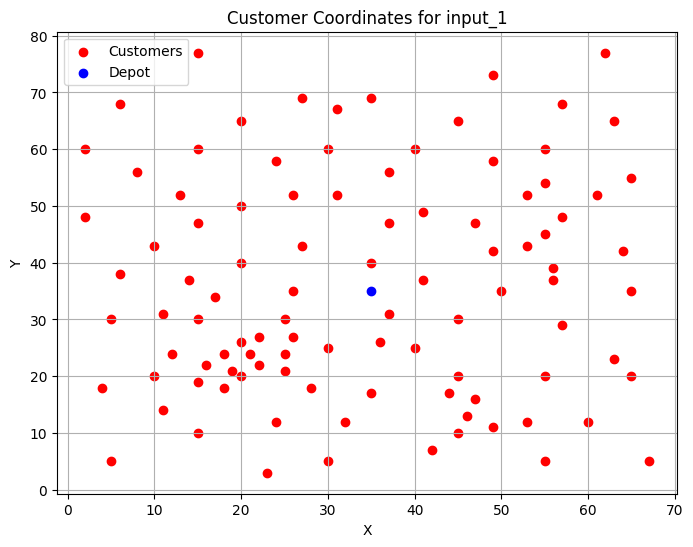

In [301]:
x_input1 = [x["x"] for x in input1]
y_input1 = [x["y"] for x in input1]

x_input2 = [x["x"] for x in input2]
y_input2 = [x["y"] for x in input2]

x_input3 = [x["x"] for x in input3]
y_input3 = [x["y"] for x in input3]


plot_customers(x_input1, y_input1, "input_1")

In [302]:
#Best solution routes 
def plot_best_solution(x, title):
    plt.figure(figsize=(8, 6))
    routes = x.get_routes()
    for route in routes:
        x_points  = np.array([x.depot["x"]])
        x_points = np.append(x_points, [x.data[i]["x"] for i in route], axis = 0)
        x_points = np.append(x_points, [x.depot["x"]], axis = 0)
        y_points  = np.array([x.depot["y"]])
        y_points = np.append(y_points, [x.data[i]["y"] for i in route], axis = 0)
        y_points = np.append(y_points, [x.depot["y"]], axis = 0) 

        plt.plot(x_points, y_points)
    
    plt.title(title)
    plt.show

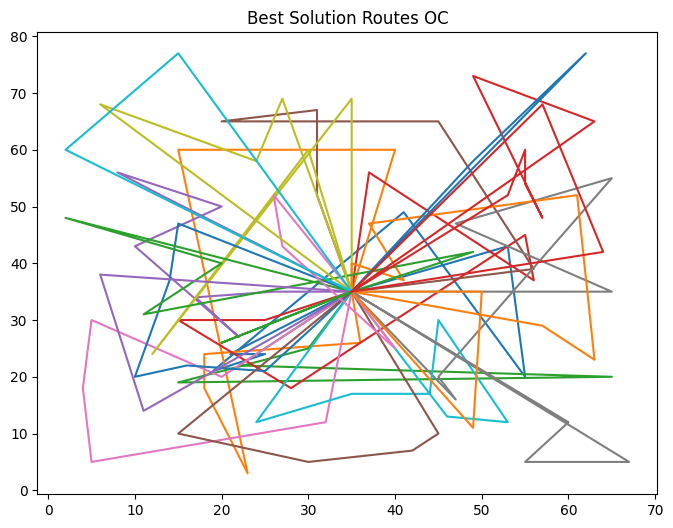

In [303]:
plot_best_solution(ga_order_crossover, "Best Solution Routes OC")
# plot_best_solution(ga_pmc, "Best Solution Routes PMX")
# plot_best_solution(ga_brbac, "Best Solution Routes BRBAC") 

In [304]:
def best_solution_evolution(solutions, title, info):
    plt.figure(figsize=(8, 6))
    y_points = [[] for _ in range(len(solutions))]
    i = 0
    for solution in solutions:
        y_points[i] = [x.fitness for x in solution]
        i+=1
    
    for i,y in enumerate(y_points):
        plt.plot(np.array(y), label = info[i])
    plt.title(title)
    plt.ylabel("fitness")
    plt.xlabel("generation")
    plt.legend()
    plt.show()

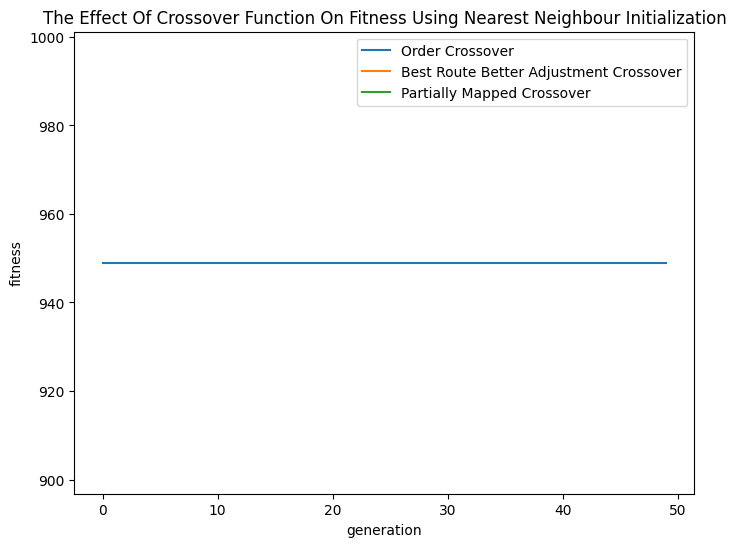

In [305]:
best_solution_evolution([best_solutions_order_crossover,[], []], "The Effect Of Crossover Function On Fitness Using Nearest Neighbour Initialization", ["Order Crossover", "Best Route Better Adjustment Crossover", "Partially Mapped Crossover"])

In [ ]:
ga_order_crossover.solution